In [6]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(os.getcwd() + '/database'))
import db_api

sys.path.append(os.path.abspath(os.getcwd() + '/engine'))
from classifiers import *
from feature_engineering import *

db = db_api.db_api()

In [7]:
# What stats are available
stats = db.get_items('stats')
#for stat in stats:
#    print stat.name

In [8]:
# Retrieve all MSUs from the DB
msus = db.get_items('msus')
for msu in msus:
    print 'ID: ' + str(msu.msu) + ', TYPE: ' + msu.msu_type.name

ID: 10, TYPE: socket
ID: 11, TYPE: socket
ID: 12, TYPE: socket
ID: 13, TYPE: read
ID: 14, TYPE: read
ID: 15, TYPE: read
ID: 16, TYPE: read
ID: 17, TYPE: read
ID: 18, TYPE: read
ID: 19, TYPE: read
ID: 20, TYPE: read
ID: 21, TYPE: read
ID: 22, TYPE: regex
ID: 23, TYPE: regex
ID: 24, TYPE: regex
ID: 25, TYPE: regex
ID: 26, TYPE: regex
ID: 27, TYPE: regex
ID: 28, TYPE: regex_route
ID: 29, TYPE: regex_route
ID: 30, TYPE: regex_route
ID: 31, TYPE: write
ID: 32, TYPE: write
ID: 33, TYPE: write
ID: 34, TYPE: http
ID: 35, TYPE: http
ID: 36, TYPE: http


In [9]:
df = db.get_msu_full_df(msus[3])

# Some feature engineering
gen_activity_ratio(df)
gen_mem_per_state(df)

# Scale fields between {0,1}
scale_fields = ['EXEC_TIME', 'IDLE_TIME', 'QUEUE_LEN', 'MEMORY_ALLOCATED', 'MEM_PER_STATE']
normalize_df(df, scale_fields)

# Split train and test
fields = ['EXEC_TIME', 'IDLE_TIME', 'QUEUE_LEN', 'MEMORY_ALLOCATED', 'ACTIVITY_RATIO', 'MEM_PER_STATE']
attack_start = df.TIME[0] + 310 * 1e9

print attack_start
X_train =  df[df.TIME <= attack_start].loc[:, fields]
X_test = df[df.TIME > attack_start].loc[:, fields]

1.51190010649e+18


In [75]:
### Setup for classification
from sklearn.model_selection import StratifiedKFold

df["LABEL"] = df.apply(lambda row: 0 if row["TIME"] < attack_start else 1, axis=1)
X = df[fields]
Y = df["LABEL"]

def calculate_acc(Y_pred, Y_true):
    num_errors = np.sum(np.abs(Y_pred-Y_true))
    return 1 - (num_errors * 1.0 / Y_pred.size)

def run_classification(clf, X, Y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        trained_clf = clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(calculate_acc(Y_pred, Y_test))
    return clf.fit(X, Y)

In [76]:
### Logistic regression ###
from sklearn import linear_model

logreg_clf = linear_model.LogisticRegression()
trained_clf = run_classification(logreg_clf, X, Y, 5)

0.0276679841897
0.0276679841897
0.0237154150198
0.0357142857143
0.0278884462151


0.00790513833992
0.0197628458498
0.0118577075099
0.0436507936508
0.0199203187251


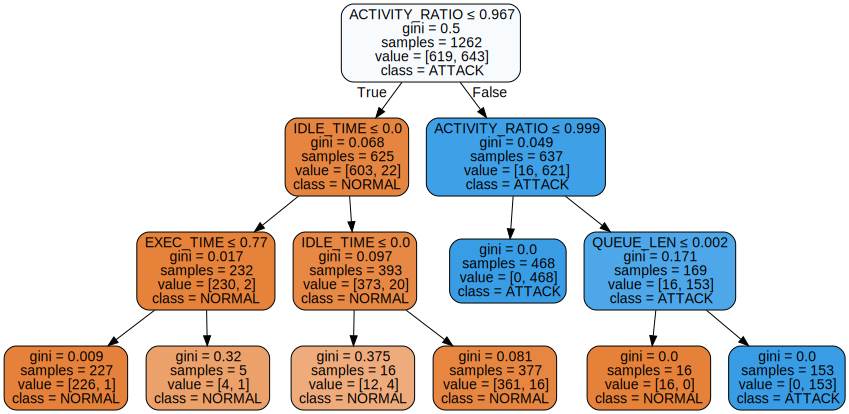

In [77]:
### Decision tree ###
from sklearn import tree
import graphviz

tree_clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
trained_clf = run_classification(tree_clf, X, Y, 5)
    
data = tree.export_graphviz(trained_clf, out_file=None, feature_names=fields, class_names=["NORMAL", "ATTACK"],
                            filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(data)
graph

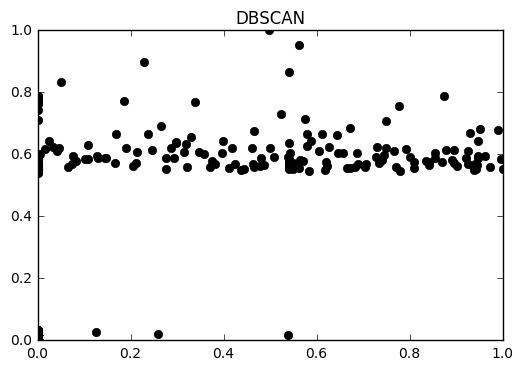

In [32]:
###DBSCAN###
X = pd.concat([X_train, X_test])

dbscan = do_dbscan(X, 0.3, 500)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[class_member_mask & ~core_samples_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN')
plt.show()

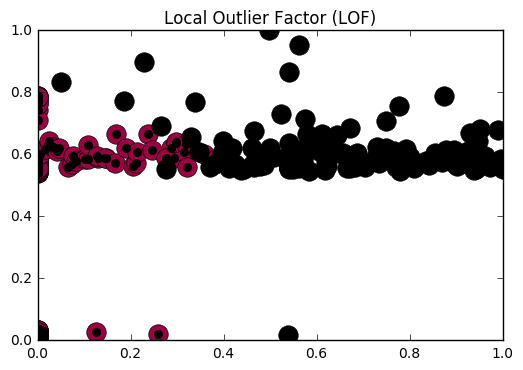

In [11]:
###LOF###
X = pd.concat([X_train,X_test])
lof = do_lof(500)
labels = lof.fit_predict(X)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for outliers.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[~class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.axis('tight')
plt.title('Local Outlier Factor (LOF)')
plt.show()

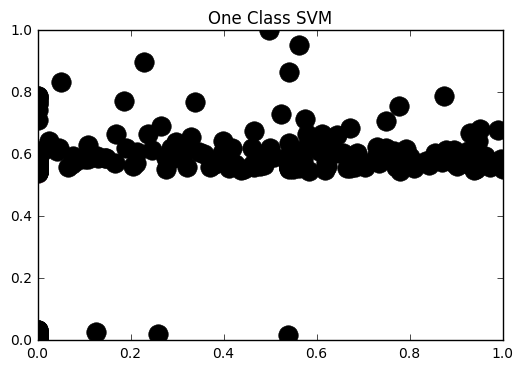

In [12]:
###One Class SVM###
X = pd.concat([X_train,X_test])
svm = do_svm(X, 'rbf', 0.1)
labels = svm.predict(X)

#print labels
#print len(X[labels == -1])

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for outliers.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
        
    xy = X[class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[~class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.axis('tight')
plt.title('One Class SVM')
plt.show()

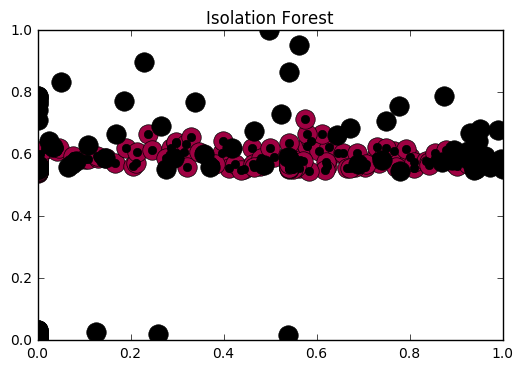

In [13]:
### Isolation Forest###
X = pd.concat([X_train,X_test])
svm = do_isolation_forest(X, len(X), 42)
labels = svm.predict(X)

#print labels
#print len(X[labels == -1])

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for outliers.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
        
    xy = X[class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[~class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.axis('tight')
plt.title('Isolation Forest')
plt.show()